---
title: 3 Layer Stacked QG Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Stacked QG
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: roxyboy.guppy@gmail.com
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import einops
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import typing as tp
import einops

from jaxsw._src.operators.functional import advection as F_adv
from jaxsw._src.operators.functional import geostrophic as F_geos
from jaxsw._src.operators.functional import cgrid as F_cgrid
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.operators.functional import interp as F_interp
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz
from jaxsw._src.models import qg as F_qg
import jaxsw._src.domain.base_v2 as Domain
from jaxsw._src.domain.qg import create_qg_multilayer_mat, LayerDomain
from jaxsw._src.masks import Mask
from jaxsw._src.operators.functional.finitevol.interp import x_average_2D, y_average_2D, center_average_2D
from jaxsw._src.operators.functional.interp import flux as F_flux

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from loguru import logger


def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(15, 4))

    for i in range(num_axis):
        pts = ax[i].imshow(field[i].T, origin="lower", cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    jax.debug.print(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In [3]:
F_qg.PDEParams??

Init signature: F_qg.PDEParams(*args, **kwargs)
Docstring:      PDEParams(*args, **kwargs)
Source:        
class PDEParams(eqx.Module):
    f0: float = 9.375e-5  # coriolis [s^-1]
    beta: float = 1.754e-11  # coriolis gradient [m^-1 s^-1]
    tau0: float = 2.0e-5  # wind stress magnitude m/s^2
    y0: float = 2_400_000.0  # [m]
    a_2: float = 0.0  # laplacian diffusion coef (m^2/s)
    a_4: float = 5.0e11  # LR # 2.0e9 # HR
    bcco: float = 0.2  # boundary condition coef. (non-dim.)
    delta_ek: float = 2.0  # eckman height [m]

    @property
    def zfbc(self):
        return self.bcco / (1.0 + 0.5 * self.bcco)
File:           ~/code_projects/jaxsw/jaxsw/_src/models/qg/__init__.py
Type:           _ModuleMeta
Subclasses:     

In [4]:
from jaxsw._src.operators.functional.dst import (
    helmholtz_dst, 
    laplacian_dst, 
    inverse_elliptic_dst, 
    dstI2D, dstI1D,
    inverse_elliptic_dst_cmm,
    helmholtz_fn,
    compute_capacitance_matrices
)

In [5]:
# Domain??

In [6]:
# Low Resolution
# Nx, Ny = 128, 128
Nx, Ny = 256, 256
# High Resolution
# Nx, Ny = 769, 961

# Lx, Ly = 3840.0e3, 4800.0e3
Lx, Ly = 5_120.0e3, 5_120.0e3

dx, dy = Lx / Nx, Ly / Ny

xy_domain = Domain.Domain(
    xmin=(0.0,0.0), 
    xmax=(Lx,Ly),
    Lx=(Lx,Ly),
    Nx=(Nx, Ny), dx=(dx, dy)
)

params = F_qg.PDEParams(y0=0.5 * Ly)

In [7]:
xy_domain

Domain(
  xmin=(0.0, 0.0),
  xmax=(5120000.0, 5120000.0),
  dx=(20000.0, 20000.0),
  Nx=(256, 256),
  Lx=(5120000.0, 5120000.0),
  ndim=2
)

In [21]:
# # octogonal domain
# domain_type = "octogonal"
# mask = np.ones((Nx-1,Ny-1))
# for i in range(Nx//4):
#     for j in range(Ny//4):
#         if i+j < min(Nx//4, Ny//4):
#             mask[i,j] = 0.
#             mask[i,-1-j] = 0.
#             mask[-1-i,j] = 0.
#             mask[-1-i,-1-j] = 0.
            
# masks = Mask.init_mask(mask, variable="q")

domain_type = "rectangular"

mask = jnp.ones((Nx,Ny))
mask = mask.at[0].set(0.0)
mask = mask.at[-1].set(0.0)
mask = mask.at[:,0].set(0.0)
mask = mask.at[:,-1].set(0.0)

masks = Mask.init_mask(mask, variable="psi")

In [22]:
!pwd

/Users/eman/code_projects/jaxsw/notebooks/dev/eman/QG_Multilayer


In [23]:
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_090d.npy")
# psi0.shape

In [24]:


# heights
# heights = [350.0, 750.0, 2900.0]
heights = [400.0, 1_100.0, 2_600.0]

# reduced gravities
reduced_gravities = [0.025, 0.0125]

# initialize layer domain
layer_domain = LayerDomain(heights, reduced_gravities, correction=False)
print_debug_quantity(layer_domain.A_layer_2_mode, "CL2M")
print_debug_quantity(layer_domain.A_mode_2_layer, "CM2L")

# from jaxsw._src.operators.functional import elliptical as F_elliptical
H_mat = F_qg.calculate_helmholtz_dst(xy_domain, layer_domain, params)


psi0 = jnp.zeros(shape=(layer_domain.Nz,) + xy_domain.Nx)
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_000y_360d.npy")[0]
lambda_sq = params.f0**2 *einops.rearrange(layer_domain.lambda_sq, "Nz -> Nz 1 1")
homsol = F_qg.compute_homogeneous_solution(
    psi0, 
    lambda_sq=lambda_sq,
    H_mat=H_mat
)
print_debug_quantity(homsol, "HOMSOL")

# CALCULATE CAPCITANCE MATRIX
if domain_type == "octogonal":
    cap_matrices = compute_capacitance_matrices(
        H_mat, 
        masks.psi.irrbound_xids,
        masks.psi.irrbound_yids
    )
else:
    cap_matrices = None


# calculate homogeneous solution
homsol_i = center_average_2D(homsol) * masks.q.values

homsol_mean = einops.reduce(homsol_i, "Nz Nx Ny -> Nz 1 1", reduction="mean")
print_debug_quantity(homsol_mean, "HOMSOL MEAN")

dst_sol = F_qg.DSTSolution(
    homsol=homsol, 
    homsol_mean=homsol_mean, 
    H_mat=H_mat,
    capacitance_matrix=cap_matrices
)

# PV
q = F_qg.calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.psi, 
    masks_q=masks.q
)

fn = jax.vmap(F_qg.advection_rhs, in_axes=(0,0,None,None,None,None,None))

div_flux = fn(
    q, psi0, xy_domain.dx[-2],xy_domain.dx[-1], 3, masks.u, masks.v
    # q, psi0, xy_domain.dx[-2],xy_domain.dx[-1], 1, None, None,
)

bottom_drag = F_qg.calculate_bottom_drag(
    psi=psi0, 
    domain=xy_domain, 
    H_z=layer_domain.heights[-1],
    f0=params.f0, 
    masks_psi=masks.psi
)

wind_forcing = F_qg.calculate_wind_forcing(
    domain=xy_domain,
    H_0=layer_domain.heights[0],
    tau0=0.08/1_000.0,
)


CL2M: (3, 3) | -1.121135e+00 | 1.924501e-01 | 1.924501e-01 | 1.098374e+00
CM2L: (3, 3) | -5.896234e-01 | 3.351947e-01 | 3.351947e-01 | 9.110659e-01
SOL: (3, 256, 256) | -1.916119e+12 | -3.030732e+11 | -3.030732e+11 | 0.000000e+00
LAMBDA SQ: (3, 1, 1) | -2.068729e-26 | 7.027153e-10 | 7.027153e-10 | 1.528576e-09
HOMSOL: (3, 256, 256) | -2.220446e-15 | 3.565769e-01 | 3.565769e-01 | 1.000000e+00
HOMSOL MEAN: (3, 1, 1) | 2.140031e-02 | 3.515206e-01 | 3.515206e-01 | 1.000000e+00


In [25]:
dq, dpsi = F_qg.qg_rhs(
    q=q, 
    psi=psi0, 
    domain=xy_domain,
    params=params, 
    layer_domain=layer_domain,
    dst_sol=dst_sol, 
    wind_forcing=wind_forcing,
    bottom_drag=bottom_drag,
    masks=masks
)


In [26]:
class State(eqx.Module):
    q: Array
    psi: Array

In [27]:
def vector_field(t: float, state: State, args) -> State:
    
    dq, dpsi = F_qg.qg_rhs(
        q=state.q, psi=state.psi,
        domain=xy_domain, params=params,
        layer_domain=layer_domain,
        dst_sol=dst_sol,
        wind_forcing=wind_forcing,
        bottom_drag=bottom_drag,
        masks=masks
    )
    
    state = eqx.tree_at(lambda x: x.q, state, dq)
    state = eqx.tree_at(lambda x: x.psi, state, dpsi)
    
    return state

In [34]:
dt = 4_000

tmin = 0.0
num_days = 360 # 180 # 
tmax = pd.to_timedelta(num_days, unit="days").total_seconds()
num_save = 20

In [35]:
from jaxsw._src.domain.time import TimeDomain

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

In [36]:
# Euler, Constant StepSize
# solver = dfx.Tsit5()
solver = dfx.Bosh3()

# Tolerances
stepsize_controller = dfx.PIDController(rtol=1e-5, atol=1e-5)
# stepsize_controller = dfx.ConstantStepSize()

In [37]:
psi0 = jnp.zeros(shape=(layer_domain.Nz,) + xy_domain.Nx)
# psi0 = np.load("/Users/eman/code_projects/data/qg_runs/psi_0.986y_360.00d_octogonal.npy")

q = F_qg.calculate_potential_vorticity(
    psi0, xy_domain, layer_domain, 
    params=params,
    masks_psi=masks.psi, 
    masks_q=masks.q
)

state_init = State(q=q, psi=psi0)

In [38]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 2min 13s, sys: 5.42 s, total: 2min 18s
Wall time: 1min 20s


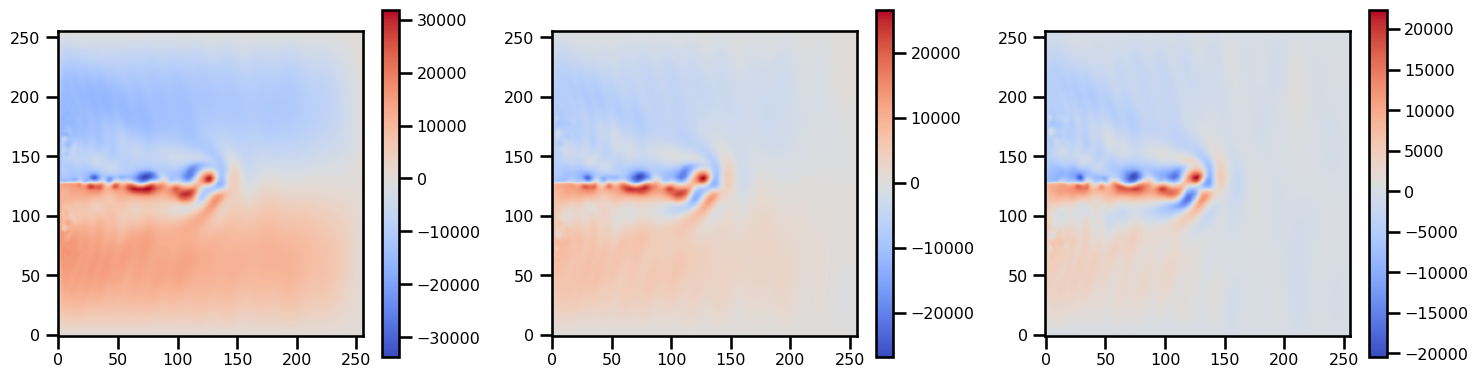

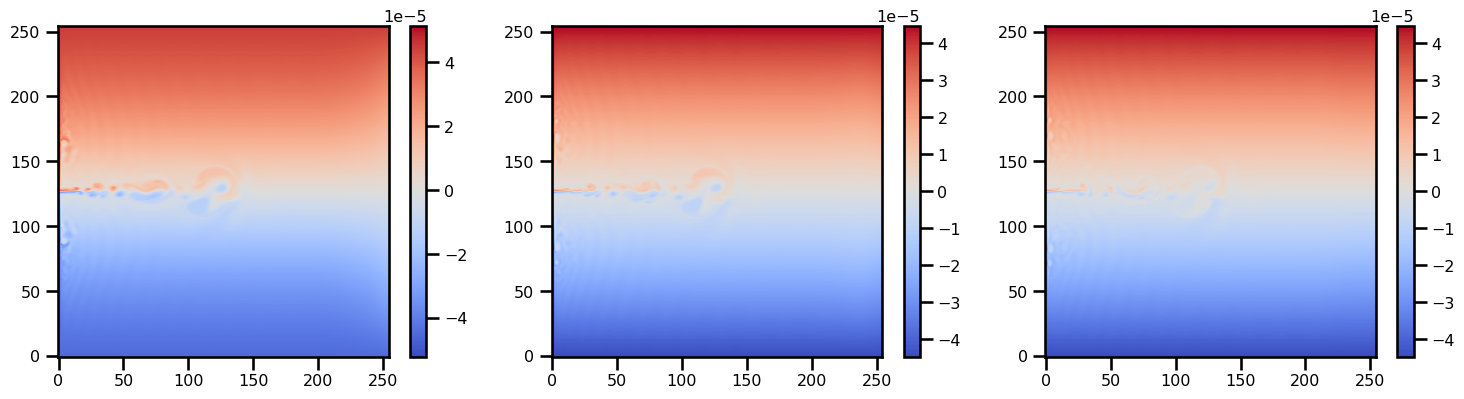

In [39]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])

### Re-Run Simulation

In [42]:
%%time
# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(vector_field),
    solver=solver,
    t0=tmin,
    t1=tmax,
    dt0=dt,
    y0=State(sol.ys.q[-1], sol.ys.psi[-1]),
    saveat=saveat,
    args=None,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

CPU times: user 1min 38s, sys: 3.2 s, total: 1min 41s
Wall time: 57.2 s


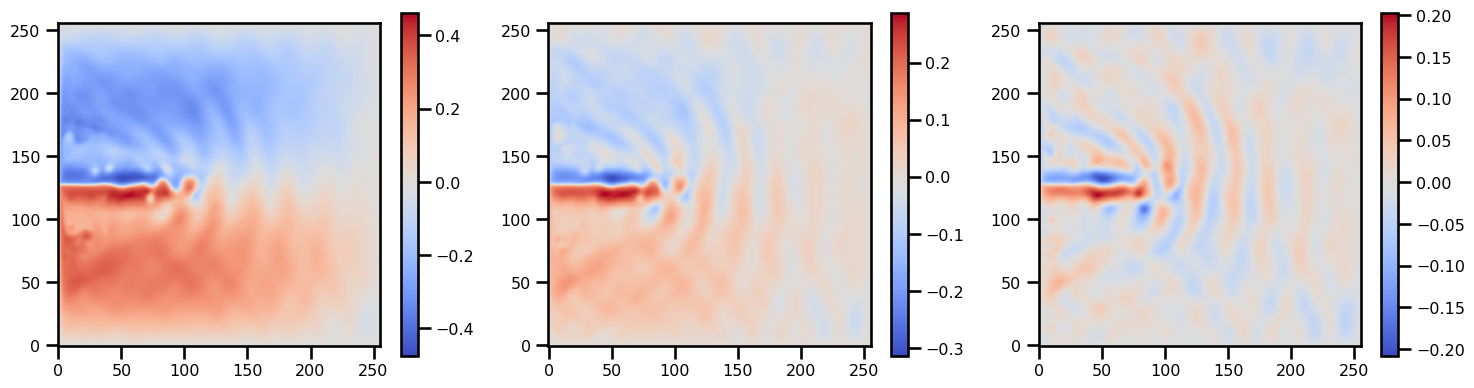

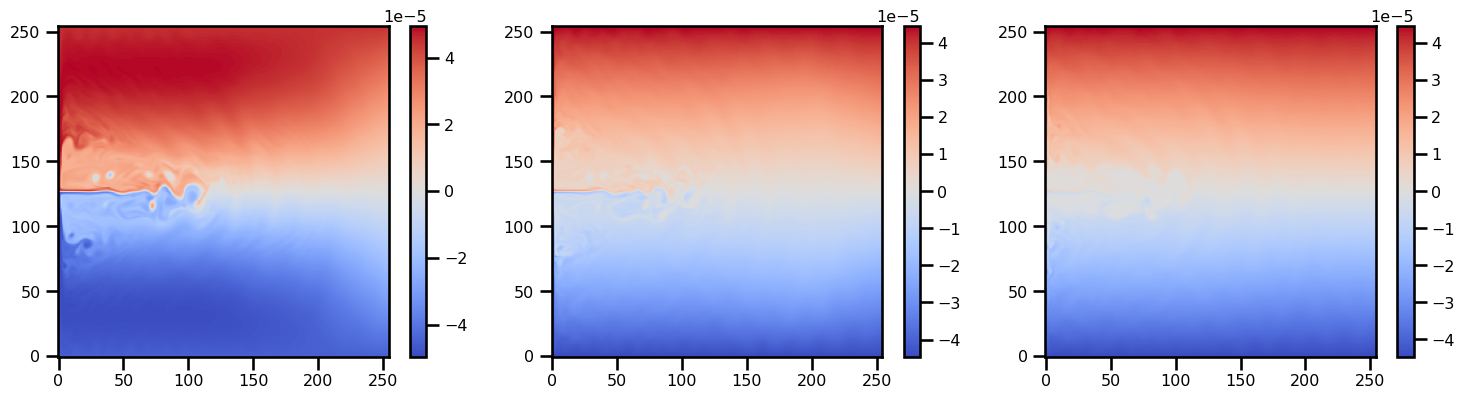

In [43]:
plot_field(sol.ys.psi[-1]/ (9.81 / params.f0))
plot_field(sol.ys.q[-1])